# Machine Learning Models for Text Classification  

In this notebook, we will train and evaluate different **Machine Learning models** for **text classification** using the **TF-IDF features** extracted in the previous steps.  

We will use the **TF-IDF matrix (`Xtrain_matrix.pkl`)** as input features and the **target labels (`y_train_encoded.pkl`)** for supervised learning.  
The **test dataset (`Xtest_matrix.pkl`)** will not be used at this stage, as it is reserved for **final result submission**.  

We will start by experimenting with the following models:  
- **Logistic Regression**  
- **Support Vector Machines (SVM)**  
- **Random Forest Classifier**  
- **K-Neighbors Classifier**  
- **Decision Tree Classifier**
- **XGBoost**  
- **Linear SVC** 
- **Voting Classifier**  

📌 **These models have been selected based on standard text classification approaches, but we may adjust our choices depending on their performance.**  

We will perform a **simple hyperparameter search** for all models, optimizing for the **weighted F1-score**, as this metric is required to evaluate the classification performance in the context of the project and challenge.  

By the end of this notebook, we will:  
✔ Compare the performance of different models  
✔ Optimize hyperparameters if necessary  
✔ Select and save the best-performing model for future use  


## 2. Import Required Libraries 

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


import sys
import os
from pathlib import Path
import pickle
import pandas as pd

# Machine Learning models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Model selection and hyperparameter tuning
from sklearn.model_selection import train_test_split, GridSearchCV
# Evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Loading Preprocessed Data  

Before training our Machine Learning models, we need to load the **TF-IDF matrix (`Xtrain_matrix.pkl`)** and the **target labels (`ytrain.pkl`)**.  


In [2]:
# Get the current notebook directory
CURRENT_DIR = Path(os.getcwd()).resolve()

# Automatically find the project root (go up 3 levels)
PROJECT_ROOT = CURRENT_DIR.parents[2]

# Add project root to sys.path
sys.path.append(str(PROJECT_ROOT))

# Function to get relative paths from project root
def get_relative_path(absolute_path):
    return str(Path(absolute_path).relative_to(PROJECT_ROOT))

# Print project root directory
print(f"Project Root Directory: {PROJECT_ROOT.name}")  # Display only the root folder name

import config  # Now Python can find config.py

# Paths to load
tfidf_path = Path(config.XTRAIN_MATRIX_PATH)
labels_path = Path(config.YTRAIN_ENCODED_PATH)

# Print paths being used (relative to project root)
print(f"Using Config File from: {get_relative_path(config.__file__)}")
print(f"Loading TF-IDF matrix from: {get_relative_path(tfidf_path)}")
print(f"Loading encoded labels from: {get_relative_path(labels_path)}")

# Check if files exist before loading
if not tfidf_path.exists():
    raise FileNotFoundError(f"Error: TF-IDF matrix file not found at {get_relative_path(tfidf_path)}")

if not labels_path.exists():
    raise FileNotFoundError(f"Error: Encoded labels file not found at {get_relative_path(labels_path)}")

# Load the TF-IDF matrix
X = pickle.load(open(tfidf_path, "rb"))

# Load the classification labels
y = pd.read_pickle(labels_path)

# Print confirmation
print("Data Successfully Loaded!")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")


Project Root Directory: Data_Scientist_Rakuten_Project-main
Using Config File from: config.py
Loading TF-IDF matrix from: data\processed\text\Xtrain_matrix.pkl
Loading encoded labels from: data\processed\text\y_train_encoded.pkl
Data Successfully Loaded!
X shape: (84916, 5000)
y shape: (84916,)


## 2. Splitting Data into Training and Validation Sets

In [3]:
# Split data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(f"Split Completed:")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


Split Completed:
X_train shape: (67932, 5000), y_train shape: (67932,)
X_test shape: (16984, 5000), y_test shape: (16984,)


## 3. Training Machine Learning Models  

### 3.1 Logistic Regression

To optimize the **Logistic Regression** model, we perform a **GridSearchCV** on key hyperparameters, aiming to maximize the **weighted F1-score** to handle class imbalances effectively:

- `multi_class`: Defines the type of classification (`multinomial` for multi-class problems).
- `class_weight`: Balances classes for imbalanced data (`balanced`, `None`, or custom dictionaries).
- `max_iter`: Controls the number of iterations for convergence.
- `C`: Regularization strength, which can impact model performance.
- `solver`: Specifies the algorithm for optimization (e.g., `lbfgs`, `saga`, `liblinear`).

- **GridSearchCV** for Logistic Regression

In [4]:
# Define a simplified parameter grid
param_grid = {
    'multi_class': ['multinomial'],  # Utilisation de 'multinomial' pour la classification multiclasse
    'class_weight': ['balanced', None],  # Class weights équilibrés ou pas
    'max_iter': [500, 1000, 1500],  # Valeurs d'itérations pour la convergence
}

# Initialize Logistic Regression model
log_reg = LogisticRegression()

# Perform GridSearchCV based on 'weighted F1-score'
grid_search = GridSearchCV(log_reg, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Extract best model
best_log_reg = grid_search.best_estimator_

# Display best hyperparameters
print(f"Best Hyperparameters for Logistic Regression: {grid_search.best_params_}")

Best Hyperparameters for Logistic Regression: {'class_weight': None, 'max_iter': 500, 'multi_class': 'multinomial'}


- **Re-train** Logistic Regression with the best hyperparameters.

In [5]:
# After GridSearchCV has finished
# Retrain Logistic Regression with the best hyperparameters
clf_lr = LogisticRegression(
    multi_class=grid_search.best_params_['multi_class'],  # Best 'multi_class' parameter
    class_weight=grid_search.best_params_['class_weight'],  # Best 'class_weight' parameter
    max_iter=grid_search.best_params_['max_iter'],  # Best 'max_iter' parameter
    # Removing 'C' and 'solver' as we're not using them in the simplified grid
)
clf_lr.fit(X_train, y_train)

# Print the best hyperparameters used for retraining
print(f"Model retrained with the following best hyperparameters:\n"
      f"multi_class: {grid_search.best_params_['multi_class']}\n"
      f"class_weight: {grid_search.best_params_['class_weight']}\n"
      f"max_iter: {grid_search.best_params_['max_iter']}")


Model retrained with the following best hyperparameters:
multi_class: multinomial
class_weight: None
max_iter: 500


- **Evaluate** Logistic Regression with the best hyperparameters.

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.34      0.56      0.42       624
           1       0.59      0.74      0.65       998
           2       0.75      0.80      0.77       318
           3       0.67      0.64      0.66       963
           4       0.71      0.61      0.65       555
           5       0.88      0.88      0.88       982
           6       0.80      0.67      0.73       526
           7       0.80      0.84      0.82       996
           8       0.64      0.46      0.54       391
           9       0.88      0.91      0.90       854
          10       0.75      0.68      0.72       951
          11       0.74      0.72      0.73       558
          12       0.95      0.97      0.96      2034
          13       0.77      0.45      0.56       155
          14       0.87      0.90      0.88       998
          15       0.80      0.66      0.72       283
          16       0.80      0.79 

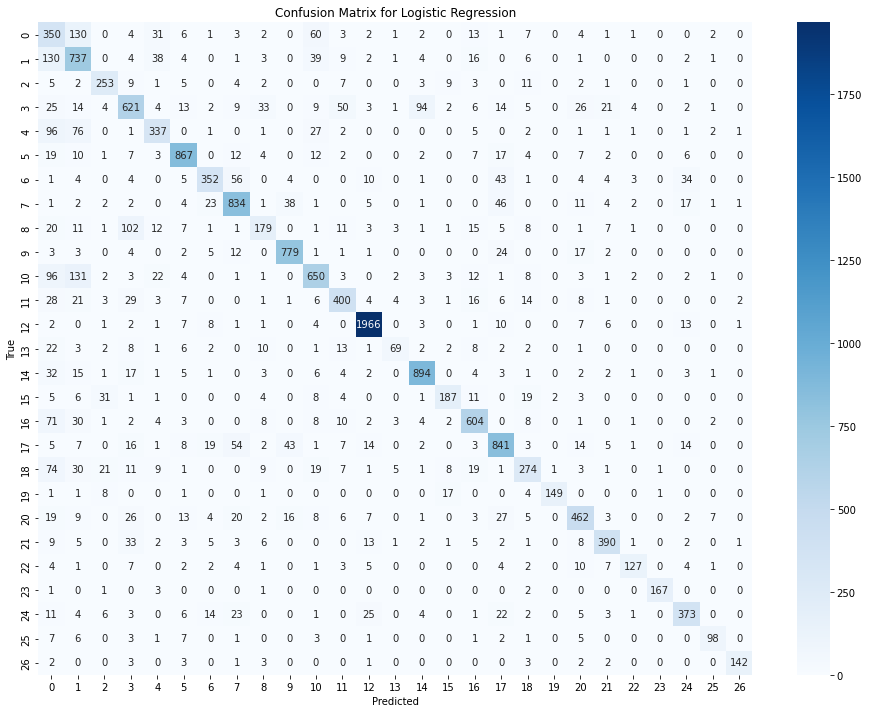

In [6]:
# Evaluate Logistic Regression model
y_pred = clf_lr.predict(X_test)  # Make predictions on the test set

# Print the classification report
print("Classification Report for Logistic Regression:")
print(classification_report(y_test, y_pred))

# Optionally, calculate other evaluation metrics like F1-Score, Accuracy
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = clf_lr.score(X_test, y_test)

# Display the evaluation metrics
print(f"Weighted F1-Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
print("Confusion Matrix for Logistic Regression:")
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(16,12))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(len(cm)), yticklabels=range(len(cm)))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Logistic Regression")
plt.show()



- **Save** the best Logistic Regression model.

In [7]:
# Print the path where the  best Logistic Regression model will be saved
print(f"Saving the model to: {config.CLASSICAL_MODELS_DIR}")

try:
    # Try to save the trained Logistic Regression model
    with open(os.path.join(config.CLASSICAL_MODELS_DIR, "best_lr_model.pkl"), "wb") as f:
        pickle.dump(best_log_reg, f)
    print("\n Best Logistic Regression model saved successfully.")
except Exception as e:
    # In case of an error, print the error message
    print(f"\nError occurred while saving the model: {e}")


Saving the model to: D:\Data_Science\Append_Data_Engineer_AWS_MLOPS\Data_Scientist_Rakuten_Project-main\models\text\classical

 Best Logistic Regression model saved successfully.


### 3.2 Support Vector Machines (SVM)

To optimize the **Support Vector Machines (SVM)** model, we perform a **GridSearchCV** on key hyperparameters, aiming to maximize the **weighted F1-score** to effectively handle class imbalances:

- `C`: Regularization parameter, controlling the trade-off between achieving a low error on the training set and minimizing the model complexity.
- `kernel`: Specifies the kernel type to use in the algorithm (e.g., `linear`, `rbf`, `poly`, or `sigmoid`).
- `class_weight`: Balances the classes for imbalanced data (`balanced`, `None`).
- `max_iter`: Controls the maximum number of iterations for convergence.
- `gamma`: Defines the kernel coefficient for `rbf`, `poly`, and `sigmoid` kernels. It can impact model flexibility and performance.
- `degree`: Defines the degree of the polynomial kernel function (relevant only if `kernel='poly'`).


- **GridSearchCV** for SVM

In [8]:
# Define parameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Kernel types to test
    'class_weight': ['balanced', None],  # To handle class imbalance
    'max_iter': [1000, 1500, 2000],  # Maximum iterations for convergence
    'gamma': ['scale', 'auto'],  # Kernel coefficient for 'rbf', 'poly', 'sigmoid'
    'degree': [3, 4, 5]  # Degree for 'poly' kernel (relevant only for 'poly')
}

# Initialize the SVM model
svm = SVC()

# Perform GridSearchCV based on 'weighted F1-score'
grid_search = GridSearchCV(svm, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Extract best model
best_svm = grid_search.best_estimator_

# Display best hyperparameters
print(f"Best Hyperparameters for SVM: {grid_search.best_params_}")


KeyboardInterrupt: 

- **Re-train** SVM with the best hyperparameters.

In [ ]:
# After GridSearchCV has finished

# Retrain SVM with the best hyperparameters
best_svm = SVC(
    C=grid_search.best_params_['C'],
    kernel=grid_search.best_params_['kernel'],
    class_weight=grid_search.best_params_['class_weight'],
    max_iter=grid_search.best_params_['max_iter'],
    gamma=grid_search.best_params_['gamma'],
    degree=grid_search.best_params_['degree']
)
best_svm.fit(X_train, y_train)

# Print the best hyperparameters used for retraining
print(f"Model retrained with the following best hyperparameters:\n"
      f"C: {grid_search.best_params_['C']}\n"
      f"kernel: {grid_search.best_params_['kernel']}\n"
      f"class_weight: {grid_search.best_params_['class_weight']}\n"
      f"max_iter: {grid_search.best_params_['max_iter']}\n"
      f"gamma: {grid_search.best_params_['gamma']}\n"
      f"degree: {grid_search.best_params_['degree']}")


- **Evaluate** SVM with the best hyperparameters.

In [ ]:
# Evaluate SVM model
y_pred = best_svm.predict(X_test)  # Make predictions on the test set

# Print the classification report
print("Classification Report for SVM:")
print(classification_report(y_test, y_pred))

# Optionally, calculate other evaluation metrics like F1-Score, Accuracy
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = best_svm.score(X_test, y_test)

# Display the evaluation metrics
print(f"Weighted F1-Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
print("Confusion Matrix for SVM:")
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix with a larger figure
plt.figure(figsize=(16,12))  # Adjust the size of the figure
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(len(cm)), yticklabels=range(len(cm)))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for SVM")
plt.show()


- **Save** the best SVM model.

In [ ]:
# Print the path where the best SVM model will be saved
print(f"Saving the model to: {config.CLASSICAL_MODELS_DIR}")

try:
    # Try to save the trained SVM model
    with open(os.path.join(config.CLASSICAL_MODELS_DIR, "best_svm_model.pkl"), "wb") as f:
        pickle.dump(best_svm, f)
    print("\nBest SVM model saved successfully.")
except Exception as e:
    # In case of an error, print the error message
    print(f"\nError occurred while saving the model: {e}")


### 3.3 Random Forest Classifier

To optimize the **Random Forest Classifier** model, we perform a **GridSearchCV** on key hyperparameters, aiming to maximize the **weighted F1-score** to effectively handle class imbalances:

- `n_estimators`: The number of trees in the forest. More trees usually improve model performance, but also increase computation time.
- `max_depth`: The maximum depth of the trees. Limiting the depth can prevent overfitting.
- `min_samples_split`: The minimum number of samples required to split an internal node. This can control overfitting by setting higher values.
- `min_samples_leaf`: The minimum number of samples required to be at a leaf node. A higher value can smooth the model.
- `class_weight`: Balances the classes for imbalanced data (`balanced`, `None`).
- `max_features`: The number of features to consider when looking for the best split. This can impact model performance and speed.
- `bootstrap`: Whether bootstrap samples are used when building trees.

- **GridSearchCV** for Random Forest

In [ ]:
# Define parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300, 400],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required at a leaf node
    'class_weight': ['balanced', None],  # Handle class imbalance
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider at each split
    'bootstrap': [True, False]  # Whether to use bootstrap samples
}

# Initialize the Random Forest model
rf = RandomForestClassifier()

# Perform GridSearchCV based on 'weighted F1-score'
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Extract best model
best_rf = grid_search.best_estimator_

# Display best hyperparameters
print(f"Best Hyperparameters for Random Forest: {grid_search.best_params_}")


- **Re-train** Random Forest with the best hyperparameters.

In [ ]:
# After GridSearchCV has finished

# Retrain Random Forest with the best hyperparameters
best_rf = RandomForestClassifier(
    n_estimators=grid_search.best_params_['n_estimators'],
    max_depth=grid_search.best_params_['max_depth'],
    min_samples_split=grid_search.best_params_['min_samples_split'],
    min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
    class_weight=grid_search.best_params_['class_weight'],
    max_features=grid_search.best_params_['max_features'],
    bootstrap=grid_search.best_params_['bootstrap']
)
best_rf.fit(X_train, y_train)

# Print the best hyperparameters used for retraining
print(f"Model retrained with the following best hyperparameters:\n"
      f"n_estimators: {grid_search.best_params_['n_estimators']}\n"
      f"max_depth: {grid_search.best_params_['max_depth']}\n"
      f"min_samples_split: {grid_search.best_params_['min_samples_split']}\n"
      f"min_samples_leaf: {grid_search.best_params_['min_samples_leaf']}\n"
      f"class_weight: {grid_search.best_params_['class_weight']}\n"
      f"max_features: {grid_search.best_params_['max_features']}\n"
      f"bootstrap: {grid_search.best_params_['bootstrap']}")


- **Evaluate** Random Forest with the best hyperparameters.

In [ ]:
# Evaluate Random Forest model
y_pred = best_rf.predict(X_test)  # Make predictions on the test set

# Print the classification report
print("Classification Report for Random Forest:")
print(classification_report(y_test, y_pred))

# Optionally, calculate other evaluation metrics like F1-Score, Accuracy
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = best_rf.score(X_test, y_test)

# Display the evaluation metrics
print(f"Weighted F1-Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
print("Confusion Matrix for Random Forest:")
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix with a larger figure
plt.figure(figsize=(16,12))  # Adjust the size of the figure
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(len(cm)), yticklabels=range(len(cm)))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Random Forest")
plt.show()


- **Save** the best Random Forest model.

In [ ]:
# Print the path where the best Random Forest model will be saved
print(f"Saving the model to: {config.CLASSICAL_MODELS_DIR}")

try:
    # Try to save the trained Random Forest model
    with open(os.path.join(config.CLASSICAL_MODELS_DIR, "best_rf_model.pkl"), "wb") as f:
        pickle.dump(best_rf, f)
    print("\nBest Random Forest model saved successfully.")
except Exception as e:
    # In case of an error, print the error message
    print(f"\nError occurred while saving the model: {e}")


### 3.4 K-Neighbors Classifier

To optimize the **K-Neighbors Classifier** model, we perform a **GridSearchCV** on key hyperparameters, aiming to maximize the **weighted F1-score** to effectively handle class imbalances:

- `n_neighbors`: The number of neighbors to use for knearest neighbors classification. Increasing this value makes the model more general and reduces overfitting.
- `weights`: Function used to weight the points in the neighborhood. Options include `uniform` (all points are weighted equally) or `distance` (closer points have more influence).
- `algorithm`: The algorithm used to compute the nearest neighbors (`auto`, `ball_tree`, `kd_tree`, `brute`).
- `leaf_size`: The leaf size for the `ball_tree` and `kd_tree` algorithms. A smaller leaf size can improve search time.
- `p`: The power parameter for the Minkowski distance. When `p=2`, this corresponds to the Euclidean distance.
- `metric`: The distance metric to use. Can be `minkowski`, `manhattan`, `chebyshev`, or `cosine`.


- **GridSearchCV** for K-Neighbors

In [ ]:
# Define parameter grid for K-Neighbors Classifier
param_grid = {
    'n_neighbors': [3, 5, 7, 9],  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function for neighbors
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algorithm to compute nearest neighbors
    'leaf_size': [20, 30, 40],  # Leaf size for 'ball_tree' and 'kd_tree'
    'p': [1, 2],  # Power parameter for Minkowski distance (1 = Manhattan, 2 = Euclidean)
    'metric': ['minkowski', 'manhattan', 'chebyshev', 'cosine']  # Distance metric
}

# Initialize the K-Neighbors Classifier
knn = KNeighborsClassifier()

# Perform GridSearchCV based on 'weighted F1-score'
grid_search = GridSearchCV(knn, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Extract best model
best_knn = grid_search.best_estimator_

# Display best hyperparameters
print(f"Best Hyperparameters for K-Neighbors Classifier: {grid_search.best_params_}")


- **Re-train** K-Neighbors Classifier with the best hyperparameters.

In [ ]:
# After GridSearchCV has finished

# Retrain K-Neighbors Classifier with the best hyperparameters
best_knn = KNeighborsClassifier(
    n_neighbors=grid_search.best_params_['n_neighbors'],
    weights=grid_search.best_params_['weights'],
    algorithm=grid_search.best_params_['algorithm'],
    leaf_size=grid_search.best_params_['leaf_size'],
    p=grid_search.best_params_['p'],
    metric=grid_search.best_params_['metric']
)
best_knn.fit(X_train, y_train)

# Print the best hyperparameters used for retraining
print(f"Model retrained with the following best hyperparameters:\n"
      f"n_neighbors: {grid_search.best_params_['n_neighbors']}\n"
      f"weights: {grid_search.best_params_['weights']}\n"
      f"algorithm: {grid_search.best_params_['algorithm']}\n"
      f"leaf_size: {grid_search.best_params_['leaf_size']}\n"
      f"p: {grid_search.best_params_['p']}\n"
      f"metric: {grid_search.best_params_['metric']}")


- **Evaluate** K-Neighbors Classifier with the best hyperparameters.

In [ ]:
# Evaluate K-Neighbors Classifier model
y_pred = best_knn.predict(X_test)  # Make predictions on the test set

# Print the classification report
print("Classification Report for K-Neighbors Classifier:")
print(classification_report(y_test, y_pred))

# Optionally, calculate other evaluation metrics like F1-Score, Accuracy
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = best_knn.score(X_test, y_test)

# Display the evaluation metrics
print(f"Weighted F1-Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
print("Confusion Matrix for K-Neighbors Classifier:")
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix with a larger figure
plt.figure(figsize=(16,12))  # Adjust the size of the figure
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(len(cm)), yticklabels=range(len(cm)))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for K-Neighbors Classifier")
plt.show()

- **Save** the best K-Neighbors model.

In [ ]:
# Print the path where the best K-Neighbors model will be saved
print(f"Saving the model to: {config.CLASSICAL_MODELS_DIR}")

try:
    # Try to save the trained K-Neighbors model
    with open(os.path.join(config.CLASSICAL_MODELS_DIR, "best_knn_model.pkl"), "wb") as f:
        pickle.dump(best_knn, f)
    print("\nBest K-Neighbors model saved successfully.")
except Exception as e:
    # In case of an error, print the error message
    print(f"\nError occurred while saving the model: {e}")



### 3.5 Decision Tree Classifier

To optimize the **Decision Tree Classifier** model, we perform a **GridSearchCV** on key hyperparameters, aiming to maximize the **weighted F1-score** to effectively handle class imbalances:

- `max_depth`: The maximum depth of the tree. Limiting the depth helps to prevent overfitting.
- `min_samples_split`: The minimum number of samples required to split an internal node. This can control overfitting.
- `min_samples_leaf`: The minimum number of samples required to be at a leaf node. A higher value can smooth the model.
- `max_features`: The number of features to consider when looking for the best split. This can impact model performance and speed.
- `criterion`: The function to measure the quality of a split. Common options include `gini` (Gini impurity) and `entropy` (information gain).
- `class_weight`: Balances the classes for imbalanced data (`balanced`, `None`).
- `splitter`: The strategy used to split at each node. Options include `best` (best split) or `random` (random split).

- **GridSearchCV** for Decision Tree

In [ ]:
# Define parameter grid for Decision Tree Classifier
param_grid = {
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider at each split
    'criterion': ['gini', 'entropy'],  # Quality of a split
    'class_weight': ['balanced', None],  # Handle class imbalance
    'splitter': ['best', 'random']  # Strategy for splitting nodes
}

# Initialize the Decision Tree model
dt = DecisionTreeClassifier()

# Perform GridSearchCV based on 'weighted F1-score'
grid_search = GridSearchCV(dt, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Extract best model
best_dt = grid_search.best_estimator_

# Display best hyperparameters
print(f"Best Hyperparameters for Decision Tree: {grid_search.best_params_}")


- **Re-train** Decision Tree with the best hyperparameters.

In [ ]:
# After GridSearchCV has finished

# Retrain Decision Tree with the best hyperparameters
best_dt = DecisionTreeClassifier(
    max_depth=grid_search.best_params_['max_depth'],
    min_samples_split=grid_search.best_params_['min_samples_split'],
    min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
    max_features=grid_search.best_params_['max_features'],
    criterion=grid_search.best_params_['criterion'],
    class_weight=grid_search.best_params_['class_weight'],
    splitter=grid_search.best_params_['splitter']
)
best_dt.fit(X_train, y_train)

# Print the best hyperparameters used for retraining
print(f"Model retrained with the following best hyperparameters:\n"
      f"max_depth: {grid_search.best_params_['max_depth']}\n"
      f"min_samples_split: {grid_search.best_params_['min_samples_split']}\n"
      f"min_samples_leaf: {grid_search.best_params_['min_samples_leaf']}\n"
      f"max_features: {grid_search.best_params_['max_features']}\n"
      f"criterion: {grid_search.best_params_['criterion']}\n"
      f"class_weight: {grid_search.best_params_['class_weight']}\n"
      f"splitter: {grid_search.best_params_['splitter']}")


- **Evaluate** Decision Tree with the best hyperparameters.

In [ ]:
# Evaluate Decision Tree model
y_pred = best_dt.predict(X_test)  # Make predictions on the test set

# Print the classification report
print("Classification Report for Decision Tree:")
print(classification_report(y_test, y_pred))

# Optionally, calculate other evaluation metrics like F1-Score, Accuracy
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = best_dt.score(X_test, y_test)

# Display the evaluation metrics
print(f"Weighted F1-Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
print("Confusion Matrix for Decision Tree:")
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix with a larger figure
plt.figure(figsize=(16,12))  # Adjust the size of the figure
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(len(cm)), yticklabels=range(len(cm)))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Decision Tree")
plt.show()

- **Save** the best Decision Tree model.

In [ ]:
# Print the path where the best Decision Tree model will be saved
print(f"Saving the model to: {config.CLASSICAL_MODELS_DIR}")

try:
    # Try to save the trained Decision Tree model
    with open(os.path.join(config.CLASSICAL_MODELS_DIR, "best_dt_model.pkl"), "wb") as f:
        pickle.dump(best_dt, f)
    print("\nBest Decision Tree model saved successfully.")
except Exception as e:
    # In case of an error, print the error message
    print(f"\nError occurred while saving the model: {e}")


### 3.6 XGBoost

To optimize the **XGBoost** model, we perform a **GridSearchCV** on key hyperparameters, aiming to maximize the **weighted F1-score** to effectively handle class imbalances:

- `n_estimators`: The number of boosting rounds (trees) to build. More trees usually improve performance but increase computation time.
- `learning_rate`: The rate at which the model learns. Smaller values make the model more robust but require more trees.
- `max_depth`: The maximum depth of the decision trees. Increasing this can make the model more complex, potentially leading to overfitting.
- `min_child_weight`: The minimum sum of instance weight (hessian) needed in a child. It can help control overfitting.
- `subsample`: The fraction of samples used for fitting each tree. A lower value can help reduce overfitting.
- `colsample_bytree`: The fraction of features to use for building each tree. It can help control overfitting.
- `gamma`: The minimum loss reduction required to make a further partition. It helps control the complexity of the model.

- **GridSearchCV** for XGBoost

In [ ]:
# Define parameter grid for XGBoost
param_grid = {
    'n_estimators': [100, 200, 300, 400],  # Number of boosting rounds (trees)
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Learning rate (step size)
    'max_depth': [3, 5, 7, 10],  # Maximum depth of the trees
    'min_child_weight': [1, 3, 5],  # Minimum sum of instance weight (hessian) needed in a child
    'subsample': [0.8, 0.9, 1.0],  # Fraction of samples to use for fitting each tree
    'colsample_bytree': [0.8, 0.9, 1.0],  # Fraction of features to use for building each tree
    'gamma': [0, 0.1, 0.2, 0.5],  # Minimum loss reduction required to make a further partition
}

# Initialize the XGBoost model
xgb = XGBClassifier()

# Perform GridSearchCV based on 'weighted F1-score'
grid_search = GridSearchCV(xgb, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Extract best model
best_xgb = grid_search.best_estimator_

# Display best hyperparameters
print(f"Best Hyperparameters for XGBoost: {grid_search.best_params_}")


- **Re-train** XGBoost with the best hyperparameters.

In [ ]:
# After GridSearchCV has finished
# Retrain XGBoost with the best hyperparameters
best_xgb = XGBClassifier(
    n_estimators=grid_search.best_params_['n_estimators'],
    learning_rate=grid_search.best_params_['learning_rate'],
    max_depth=grid_search.best_params_['max_depth'],
    min_child_weight=grid_search.best_params_['min_child_weight'],
    subsample=grid_search.best_params_['subsample'],
    colsample_bytree=grid_search.best_params_['colsample_bytree'],
    gamma=grid_search.best_params_['gamma']
)

# Fit the model
best_xgb.fit(X_train, y_train)

# Print the best hyperparameters used for retraining
print(f"Model retrained with the following best hyperparameters:\n"
      f"n_estimators: {grid_search.best_params_['n_estimators']}\n"
      f"learning_rate: {grid_search.best_params_['learning_rate']}\n"
      f"max_depth: {grid_search.best_params_['max_depth']}\n"
      f"min_child_weight: {grid_search.best_params_['min_child_weight']}\n"
      f"subsample: {grid_search.best_params_['subsample']}\n"
      f"colsample_bytree: {grid_search.best_params_['colsample_bytree']}\n"
      f"gamma: {grid_search.best_params_['gamma']}")


- **Evaluate** XGBoost with the best hyperparameters.

In [ ]:
# Evaluate XGBoost model
y_pred = best_xgb.predict(X_test)  # Make predictions on the test set

# Print the classification report
print("Classification Report for XGBoost:")
print(classification_report(y_test, y_pred))

# Optionally, calculate other evaluation metrics like F1-Score, Accuracy
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = best_xgb.score(X_test, y_test)

# Display the evaluation metrics
print(f"Weighted F1-Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
print("Confusion Matrix for XGBoost:")
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix with a larger figure
plt.figure(figsize=(16,12))  # Adjust the size of the figure
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(len(cm)), yticklabels=range(len(cm)))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for XGBoost")
plt.show()

- **Save** the best XGBoost model.

In [ ]:
# Print the path where the best XGBoost model will be saved
print(f"Saving the model to: {config.CLASSICAL_MODELS_DIR}")

try:
    # Try to save the trained XGBoost model
    with open(os.path.join(config.CLASSICAL_MODELS_DIR, "best_xgb_model.pkl"), "wb") as f:
        pickle.dump(best_xgb, f)
    print("\nBest XGBoost model saved successfully.")
except Exception as e:
    # In case of an error, print the error message
    print(f"\nError occurred while saving the model: {e}")



### 3.7 Linear SVC

To optimize the **Linear SVC** model, we perform a **GridSearchCV** on key hyperparameters, aiming to maximize the **weighted F1-score** to effectively handle class imbalances:

- `C`: Regularization parameter. It controls the trade-off between achieving a low error on the training data and minimizing the model complexity. A lower `C` encourages a simpler model.
- `max_iter`: The maximum number of iterations for the solver to converge. Higher values allow the model to converge better, especially for complex data.
- `class_weight`: Balances the classes for imbalanced data (`balanced`, `None`).
- `penalty`: Specifies the norm used in the penalization. Can be `'l1'` or `'l2'`. `l2` is the default and commonly used for Linear SVC.
- `dual`: A boolean flag to choose between the primal or dual formulation. Typically, use `dual=True` for sparse data and `dual=False` for dense data.
- `tol`: The tolerance for stopping criteria. Lower values result in higher precision but longer computation time.

- **GridSearchCV** for Linear SVC

In [ ]:
# Define parameter grid for Linear SVC
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'max_iter': [1000, 2000, 3000],  # Maximum number of iterations for solver to converge
    'class_weight': ['balanced', None],  # Handle class imbalance
    'penalty': ['l2'],  # Penalty type (l1 or l2; l2 is commonly used)
    'dual': [False],  # Typically use dual=False for dense data
    'tol': [1e-4, 1e-3, 1e-2]  # Tolerance for stopping criteria
}

# Initialize the Linear SVC model
linear_svc = LinearSVC()

# Perform GridSearchCV based on 'weighted F1-score'
grid_search = GridSearchCV(linear_svc, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Extract best model
best_lsvc = grid_search.best_estimator_

# Display best hyperparameters
print(f"Best Hyperparameters for Linear SVC: {grid_search.best_params_}")


- **Re-train** Linear SVC with the best hyperparameters.

In [ ]:
# After GridSearchCV has finished

# Retrain Linear SVC with the best hyperparameters
best_lsvc = LinearSVC(
    C=grid_search.best_params_['C'],
    max_iter=grid_search.best_params_['max_iter'],
    class_weight=grid_search.best_params_['class_weight'],
    penalty=grid_search.best_params_['penalty'],
    dual=grid_search.best_params_['dual'],
    tol=grid_search.best_params_['tol']
)
best_lsvc.fit(X_train, y_train)

# Print the best hyperparameters used for retraining
print(f"Model retrained with the following best hyperparameters:\n"
      f"C: {grid_search.best_params_['C']}\n"
      f"max_iter: {grid_search.best_params_['max_iter']}\n"
      f"class_weight: {grid_search.best_params_['class_weight']}\n"
      f"penalty: {grid_search.best_params_['penalty']}\n"
      f"dual: {grid_search.best_params_['dual']}\n"
      f"tol: {grid_search.best_params_['tol']}")

- **Evaluate** Linear SVC with the best hyperparameters.

In [ ]:
# Evaluate Linear SVC model
y_pred = best_lsvc.predict(X_test)  # Make predictions on the test set

# Print the classification report
print("Classification Report for Linear SVC:")
print(classification_report(y_test, y_pred))

# Optionally, calculate other evaluation metrics like F1-Score, Accuracy
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = best_lsvc.score(X_test, y_test)

# Display the evaluation metrics
print(f"Weighted F1-Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
print("Confusion Matrix for Linear SVC:")
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix with a larger figure
plt.figure(figsize=(16,12))  # Adjust the size of the figure
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(len(cm)), yticklabels=range(len(cm)))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Linear SVC")
plt.show()

- **Save** the best Linear SVC model.

In [ ]:
# Print the path where the best Linear SVC model will be saved
print(f"Saving the model to: {config.CLASSICAL_MODELS_DIR}")

try:
    # Try to save the trained Linear SVC model
    with open(os.path.join(config.CLASSICAL_MODELS_DIR, "best_lsvc_model.pkl"), "wb") as f:
        pickle.dump(best_lsvc, f)
    print("\nBest Linear SVC model saved successfully.")
except Exception as e:
    # In case of an error, print the error message
    print(f"\nError occurred while saving the model: {e}")


## 4. Creating a Voting Classifier
- **Combine** all the best models trained in the previous steps using a **Voting Classifier**.
- Create a **hard voting** or **soft voting** strategy depending on the models' compatibility with `predict_proba()`.

In [ ]:
# List of the best models from the previous steps
models = [
    ('lr', best_lr),  # Logistic Regression
    ('svm', best_svm),  # Support Vector Machine
    ('rf', best_rf),  # Random Forest
    ('knn', best_knn),  # K-Neighbors Classifier
    ('dt', best_dt),  # Decision Tree
    ('xgb', best_xgb),  # XGBoost
    ('lsvc', best_lsvc)  # Linear SVC
]

# Check if any model supports predict_proba(), which is required for soft voting
if any([hasattr(model[1], 'predict_proba') for model in models]):
    voting_clf = VotingClassifier(estimators=models, voting='soft')  # Soft voting
else:
    voting_clf = VotingClassifier(estimators=models, voting='hard')  # Hard voting

# Train the Voting Classifier
voting_clf.fit(X_train, y_train)

# Optionally, save the Voting Classifier
with open(os.path.join(config.MODELS_DIR, "voting_clf_model.pkl"), "wb") as f:
    pickle.dump(voting_clf, f)

print(f"Voting Classifier trained with {'soft' if voting_clf.voting == 'soft' else 'hard'} voting and saved.")


- **Evaluate** Voting Classifier with the best models.

In [ ]:
# Evaluate Voting Classifier model
y_pred = voting_clf.predict(X_test)  # Make predictions on the test set

# Print the classification report
print("Classification Report for Voting Classifier:")
print(classification_report(y_test, y_pred))

# Optionally, calculate other evaluation metrics like F1-Score, Accuracy
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = voting_clf.score(X_test, y_test)

# Display the evaluation metrics
print(f"Weighted F1-Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
print("Confusion Matrix for Voting Classifier:")
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix with a larger figure
plt.figure(figsize=(16,12))  # Adjust the size of the figure
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(len(cm)), yticklabels=range(len(cm)))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Voting Classifier")
plt.show()

## 5. Model Comparison and Selection
- **Compare** the performance of each individual model and the **Voting Classifier** using metrics like the **weighted F1-score**.
- Select the best-performing model for further use or future deployment.

In [ ]:
from sklearn.metrics import classification_report, f1_score

# Create a dictionary to store the models and their respective predictions
models = {
    'Logistic Regression': best_lr,
    'SVM': best_svm,
    'Random Forest': best_rf,
    'K-Neighbors': best_knn,
    'Decision Tree': best_dt,
    'XGBoost': best_xgb,
    'Linear SVC': best_lsvc,
    'Voting Classifier': voting_clf  # The Voting Classifier
}

# Initialize an empty dictionary to store the weighted F1 scores
f1_scores = {}

# Compare the performance of each model on the test set
for model_name, model in models.items():
    # Make predictions using the model
    y_pred = model.predict(X_test)
    
    # Calculate the weighted F1-score for the model
    f1 = f1_score(y_test, y_pred, average='weighted')
    f1_scores[model_name] = f1

    # Print the classification report for each model
    print(f"Classification Report for {model_name}:\n")
    print(classification_report(y_test, y_pred))

# Select the best-performing model based on the weighted F1-score
best_model_name = max(f1_scores, key=f1_scores.get)
best_model = models[best_model_name]

print(f"\nBest model based on weighted F1-score: {best_model_name} with a score of {f1_scores[best_model_name]:.4f}")


### Display the Mapping Between Encoded Labels and Original Classes
Before saving the best model, let's display the correspondence between the **encoded labels** (0-26) and their **original classes**. This will help us understand the mapping of the product categories in the context of our model's predictions.

In [ ]:
# Print the path where the label mapping file will be loaded from
print(f"Loading the label mapping from: {config.PRDTYPECODE_MAPPING_PATH}")

try:
    # Load the label mapping from the pickle file (Encoded Label → Original Class)
    with open(config.PRDTYPECODE_MAPPING_PATH, 'rb') as f:
        prdtypecode_mapping = pickle.load(f)

    # The DataFrame has already the three columns: "Original prdtypecode", "Encoded target", and "Label"
    mapping_df = prdtypecode_mapping  # Since it's already a DataFrame

    # Display the first 5 rows of the DataFrame after loading
    print("Label mapping loaded from pickle file:")
    print(mapping_df.head())

    # Predict using the best model (selected based on weighted F1-score)
    y_pred_best_model = best_model.predict(X_test)  # Make predictions with the best model

    # Create a DataFrame to display the classification report and results for each class
    classification_results = classification_report(y_test, y_pred_best_model, output_dict=True)
    classification_results_df = pd.DataFrame(classification_results).transpose()

    # Merge the classification results with the mapping
    classification_results_with_mapping = pd.merge(classification_results_df, mapping_df, 
                                                   left_index=True, right_on="Encoded target", how="left")

    # Display the table showing classification results and the corresponding classes
    print("Classification Report with Encoded Labels and Their Original Classes:\n")
    print(classification_results_with_mapping)

except Exception as e:
    # In case of an error, print the error message
    print(f"\nError occurred while loading the label mapping: {e}")


## 6. Saving the Best Model 
- **Save** the best model (Voting Classifier or other) for future use and potential deployment.

In [ ]:
# Print the path where the best model will be saved
best_model_path = os.path.join(config.CLASSICAL_MODELS_DIR, "best_model.pkl")
print(f"Saving the best model to: {best_model_path}")

try:
    # Try to save the best model (Voting Classifier or another model)
    with open(best_model_path, "wb") as f:
        pickle.dump(best_model, f)
    print(f"\nThe best model has been saved successfully at: {best_model_path}")
except Exception as e:
    # In case of an error, print the error message
    print(f"\nError occurred while saving the best model: {e}")


## 7. 🔄 Next Steps